# DensePose-COCO dataset and SMPL model

This document demonstrates the localization of collected points on the SMPL model.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



### Download the SMPL model
* Go to http://smpl.is.tue.mpg.de/downloads and sign up.

* Download **SMPL for Python Users** and unzip.

* Copy the file male template file 
<span style="color:#900C3F  "> **'models/basicModel_f_lbs_10_207_0_v1.0.0.pkl'** </span> to the **DensePoseData/** folder.

Now we can visualize the SMPL template model.

In [2]:
!pip install chumpy


     |████████████████████████████████| 51kB 2.4MB/s 
  Created wheel for chumpy: filename=chumpy-0.70-cp37-none-any.whl size=58291 sha256=8cf21b446c291707cca94a5d7fd41ff4430f33166afc4a0cff0a8c16780f5a15
  Stored in directory: /root/.cache/pip/wheels/0a/73/91/b8dbef9746a907c8c008fc194a9691224ca3371b55f16f1dbd
Successfully built chumpy


In [9]:
import caffe2

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import numpy as np
import pickle
import chumpy
# Now read the smpl model.
with open('/content/drive/MyDrive/DensePose-master/DensePoseData/basicmodel_m_lbs_10_207_0_v1.0.0.pkl', 'rb') as f:
    data = pickle.load(f, encoding = "latin1")
    Vertices = data['v_template']  ##  Loaded vertices of size (6890, 3)
    X,Y,Z = [Vertices[:,0], Vertices[:,1],Vertices[:,2]]

Let us define some functions to visualize the SMPL model vertices as point clouds, showing the whole body and zooming into the face:

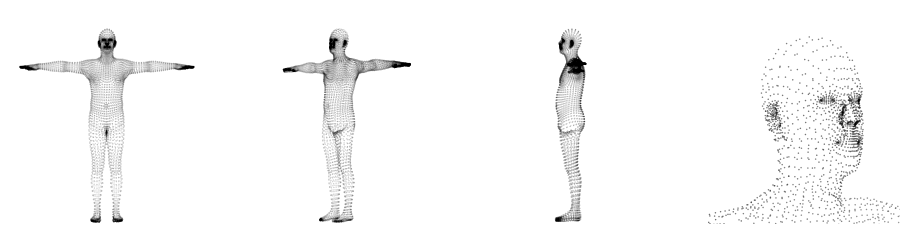

In [4]:
def smpl_view_set_axis_full_body(ax,azimuth=0):
    ## Manually set axis 
    ax.view_init(0, azimuth)
    max_range = 0.55
    ax.set_xlim( - max_range,   max_range)
    ax.set_ylim( - max_range,   max_range)
    ax.set_zlim( -0.2 - max_range,   -0.2 + max_range)
    ax.axis('off')
    
def smpl_view_set_axis_face(ax, azimuth=0):
    ## Manually set axis 
    ax.view_init(0, azimuth)
    max_range = 0.1
    ax.set_xlim( - max_range,   max_range)
    ax.set_ylim( - max_range,   max_range)
    ax.set_zlim( 0.45 - max_range,   0.45 + max_range)
    ax.axis('off')

## Now let's rotate around the model and zoom into the face.

fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(141, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')
smpl_view_set_axis_full_body(ax)

ax = fig.add_subplot(142, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')
smpl_view_set_axis_full_body(ax,45)

ax = fig.add_subplot(143, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')
smpl_view_set_axis_full_body(ax,90)

ax = fig.add_subplot(144, projection='3d')
ax.scatter(Z,X,Y,s=0.2,c='k')
smpl_view_set_axis_face(ax,-40)

plt.show()

For the sake of simplicity, we have a single densepose annotation **"demo_dp_single_ann.pkl"** for demonstration.

Below, we load the ann and find cooresponding face index and barycentric coordinates, which allows us to localize the point on the 3D surface.

In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/DensePose-master/detectron/utils')
import densepose_methods as dp_utils
import chumpy

In [ ]:
# import detectron.utils.densepose_methods as dp_utils
# import densepose_methods as dp_utils
# DP = dp_utils.DensePoseMethods()
DP = dp_utils.DensePoseMethods()
pkl_file = open('/content/drive/MyDrive/DensePose-master/DensePoseData/demo_data/demo_dp_single_ann.pkl', 'rb')
Demo = pickle.load(pkl_file, encoding='latin1')

collected_x = np.zeros(Demo['x'].shape)
collected_y = np.zeros(Demo['x'].shape)
collected_z = np.zeros(Demo['x'].shape)

for i, (ii,uu,vv) in enumerate(zip(Demo['I'],Demo['U'],Demo['V'])):
    # Convert IUV to FBC (faceIndex and barycentric coordinates.)
    FaceIndex,bc1,bc2,bc3 = DP.IUV2FBC(ii,uu,vv)
    # Use FBC to get 3D coordinates on the surface.
    p = DP.FBC2PointOnSurface( FaceIndex, bc1,bc2,bc3,Vertices )
    #
    collected_x[i] = p[0]
    collected_y[i] = p[1]
    collected_z[i] = p[2]

Lets visualize the collected points on the SMPL model:

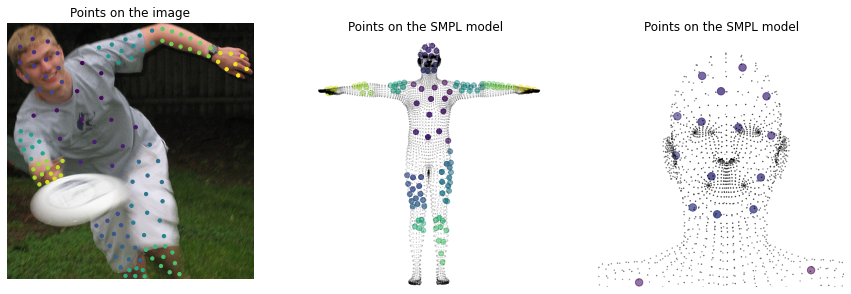

In [ ]:
fig = plt.figure(figsize=[15,5])

# Visualize the image and collected points.
ax = fig.add_subplot(131)
ax.imshow(Demo['ICrop'])
ax.scatter(Demo['x'],Demo['y'],11, np.arange(len(Demo['y']))  )
plt.title('Points on the image')
ax.axis('off'), 

## Visualize the full body smpl male template model and collected points
ax = fig.add_subplot(132, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')
ax.scatter(collected_z,  collected_x,collected_y,s=25,  c=  np.arange(len(Demo['y']))    )
smpl_view_set_axis_full_body(ax)
plt.title('Points on the SMPL model')

## Now zoom into the face.
ax = fig.add_subplot(133, projection='3d')
ax.scatter(Z,X,Y,s=0.2,c='k')
ax.scatter(collected_z,  collected_x,collected_y,s=55,c=np.arange(len(Demo['y'])))
smpl_view_set_axis_face(ax)
plt.title('Points on the SMPL model')
#
plt.show()